## General information

```
To get large and accurate data about wheat fields worldwide, plant scientists use image detection of "wheat heads"—spikes atop the plant containing grain. These images are used to estimate the density and size of wheat heads in different varieties. Farmers can use the data to assess health and maturity when making management decisions in their fields.
However, accurate wheat head detection in outdoor field images can be visually challenging. There is often overlap of dense wheat plants, and the wind can blur the photographs. Both make it difficult to identify single heads. Additionally, appearances vary due to maturity, color, genotype, and head orientation. Finally, because wheat is grown worldwide, different varieties, planting densities, patterns, and field conditions must be considered.
```

In this competition we detect wheat heads on images and return coordinates of bboxes and their confidence.

The metric is IoU:
![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

It is calculated at at different thresholds from 0.5 to 0.75 with a step size of 0.05.

My kernel is based on official tutorial: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html and could intersect with this cool kernel by Peter: https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

But this kernel I want to show you how to use Pytorch-Lightning framework for deep learning. I like the concept of this library and hope you will also find it useful.

![](https://media.publika.md/en/image/201807/full/wheat_21872400_87580900_75211700.jpg)

### Import libraries

In [1]:
!pip uninstall pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

In [2]:
!pip install hydra-core
!pip install pytorch-lightning

     |████████████████████████████████| 72 kB 183 kB/s 
     |████████████████████████████████| 233 kB 8.9 MB/s 


### import libraries

In [3]:

from __future__ import print_function
from PIL import Image
from albumentations.core.composition import Compose
from collections import defaultdict, deque
from itertools import product
from omegaconf import DictConfig, OmegaConf
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
from typing import Any, Dict, List
import albumentations as A
import ast
import copy
import cv2
import datetime
import errno
import hydra
import importlib
import json
import numpy as np
import os
import pandas as pd
import pickle
import pycocotools.mask as mask_util
import pytorch_lightning as pl
import random
import shutil
import tempfile
import time
import torch
import torch._six
import torch.distributed as dist
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions

many functions are taken from https://github.com/pytorch/vision/tree/v0.3.0/references/detection
some of them were modified for this competition

In [4]:
# different small utils

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


### coco evaluator

In [5]:
class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            coco_dt = loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.evaluate()
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################

# Ideally, pycocotools wouldn't have hard-coded prints
# so that we could avoid copy-pasting those two functions

def createIndex(self):
    # create index
    # print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in self.dataset:
        for ann in self.dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann

    if 'images' in self.dataset:
        for img in self.dataset['images']:
            imgs[img['id']] = img

    if 'categories' in self.dataset:
        for cat in self.dataset['categories']:
            cats[cat['id']] = cat

    if 'annotations' in self.dataset and 'categories' in self.dataset:
        for ann in self.dataset['annotations']:
            catToImgs[ann['category_id']].append(ann['image_id'])

    # print('index created!')

    # create class members
    self.anns = anns
    self.imgToAnns = imgToAnns
    self.catToImgs = catToImgs
    self.imgs = imgs
    self.cats = cats


maskUtils = mask_util


def loadRes(self, resFile):
    """
    Load result file and return a result api object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = COCO()
    res.dataset['images'] = [img for img in self.dataset['images']]

    # print('Loading and preparing results...')
    # tic = time.time()
    if isinstance(resFile, torch._six.string_classes):
        anns = json.load(open(resFile))
    elif type(resFile) == np.ndarray:
        anns = self.loadNumpyAnnotations(resFile)
    else:
        anns = resFile
    assert type(anns) == list, 'results in not an array of objects'
    annsImgIds = [ann['image_id'] for ann in anns]
    assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
        'Results do not correspond to current coco set'
    if 'caption' in anns[0]:
        imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
        res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
        for id, ann in enumerate(anns):
            ann['id'] = id + 1
    elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            bb = ann['bbox']
            x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]
            if 'segmentation' not in ann:
                ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
            ann['area'] = bb[2] * bb[3]
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'segmentation' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            # now only support compressed RLE format as segmentation results
            ann['area'] = maskUtils.area(ann['segmentation'])
            if 'bbox' not in ann:
                ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'keypoints' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            s = ann['keypoints']
            x = s[0::3]
            y = s[1::3]
            x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
            ann['area'] = (x2 - x1) * (y2 - y1)
            ann['id'] = id + 1
            ann['bbox'] = [x1, y1, x2 - x1, y2 - y1]
    # print('DONE (t={:0.2f}s)'.format(time.time()- tic))

    res.dataset['annotations'] = anns
    createIndex(res)
    return res


def evaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

#################################################################
# end of straight copy from pycocotools, just removing the prints
#################################################################


### coco transforms

In [6]:
def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


### coco utils

In [7]:
class FilterAndRemapCocoCategories(object):
    def __init__(self, categories, remap=True):
        self.categories = categories
        self.remap = remap

    def __call__(self, image, target):
        anno = target["annotations"]
        anno = [obj for obj in anno if obj["category_id"] in self.categories]
        if not self.remap:
            target["annotations"] = anno
            return image, target
        anno = copy.deepcopy(anno)
        for obj in anno:
            obj["category_id"] = self.categories.index(obj["category_id"])
        target["annotations"] = anno
        return image, target


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask(object):
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        # keypoints task have a slight different critera for considering
        # if an annotation is valid
        if "keypoints" not in anno[0]:
            return True
        # for keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    assert isinstance(dataset, torchvision.datasets.CocoDetection)
    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def convert_to_coco_api(ds):
    coco_ds = COCO()
    ann_id = 0
    dataset = {'images': [], 'categories': [], 'annotations': []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets, _ = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict['id'] = image_id
        img_dict['height'] = img.shape[-2]
        img_dict['width'] = img.shape[-1]
        dataset['images'].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets['labels'].tolist()
        areas = targets['area'].tolist()
        iscrowd = targets['iscrowd'].tolist()
        if 'masks' in targets:
            masks = targets['masks']
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if 'keypoints' in targets:
            keypoints = targets['keypoints']
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann['image_id'] = image_id
            ann['bbox'] = bboxes[i]
            ann['category_id'] = labels[i]
            categories.add(labels[i])
            ann['area'] = areas[i]
            ann['iscrowd'] = iscrowd[i]
            ann['id'] = ann_id
            if 'masks' in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if 'keypoints' in targets:
                ann['keypoints'] = keypoints[i]
                ann['num_keypoints'] = sum(k != 0 for k in keypoints[i][2::3])
            dataset['annotations'].append(ann)
            ann_id += 1
    dataset['categories'] = [{'id': i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    for i in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set, transforms, mode='instances'):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    t = [ConvertCocoPolysToMask()]

    if transforms is not None:
        t.append(transforms)
    transforms = Compose(t)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)

    # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset


def get_coco_kp(root, image_set, transforms):
    return get_coco(root, image_set, transforms, mode="person_keypoints")


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


### basic utils

In [8]:
# https://github.com/quantumblacklabs/kedro/blob/9809bd7ca0556531fa4a2fc02d5b2dc26cf8fa97/kedro/utils.py
def load_obj(obj_path: str, default_obj_path: str = "") -> Any:
    """Extract an object from a given path.
        Args:
            obj_path: Path to an object to be extracted, including the object name.
            default_obj_path: Default object path.
        Returns:
            Extracted object.
        Raises:
            AttributeError: When the object does not have the given named attribute.
    """
    obj_path_list = obj_path.rsplit(".", 1)
    obj_path = obj_path_list.pop(0) if len(obj_path_list) > 1 else default_obj_path
    obj_name = obj_path_list[0]
    module_obj = importlib.import_module(obj_path)
    if not hasattr(module_obj, obj_name):
        raise AttributeError(
            f"Object `{obj_name}` cannot be loaded from `{obj_path}`."
        )
    return getattr(module_obj, obj_name)


def set_seed(seed: int = 666):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def save_useful_info():
    shutil.copytree(os.path.join(hydra.utils.get_original_cwd(), 'src'),
                    os.path.join(os.getcwd(), 'code/src'))
    shutil.copy2(os.path.join(hydra.utils.get_original_cwd(), 'hydra_run.py'), os.path.join(os.getcwd(), 'code'))


def collate_fn(batch):
    return tuple(zip(*batch))


def get_training_datasets(cfg: DictConfig) -> dict:
    """
    Get datases for modelling

    Args:
        cfg: config

    Returns:

    """

    train = pd.read_csv(f'{cfg.data.folder_path}/train.csv')

    train[['x', 'y', 'w', 'h']] = pd.DataFrame(
        np.stack(train['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)

    # precalculate some values
    train['x1'] = train['x'] + train['w']
    train['y1'] = train['y'] + train['h']
    train['area'] = train['w'] * train['h']
    train_ids, valid_ids = train_test_split(train['image_id'].unique(), test_size=0.1, random_state=cfg.training.seed)

    # for fast training
    if cfg.training.debug:
        train_ids = train_ids[:10]
        valid_ids = valid_ids[:10]

    train_df = train.loc[train['image_id'].isin(train_ids)]
    valid_df = train.loc[train['image_id'].isin(valid_ids)]

    train_img_dir = f'{cfg.data.folder_path}/train'

    # initialize augmentations
    train_augs_list = [load_obj(i['class_name'])(**i['params']) for i in cfg['augmentation']['train']['augs']]
    train_bbox_params = OmegaConf.to_container((cfg['augmentation']['train']['bbox_params']))
    train_augs = A.Compose(train_augs_list, bbox_params=train_bbox_params)

    valid_augs_list = [load_obj(i['class_name'])(**i['params']) for i in cfg['augmentation']['valid']['augs']]
    valid_bbox_params = OmegaConf.to_container((cfg['augmentation']['valid']['bbox_params']))
    valid_augs = A.Compose(valid_augs_list, bbox_params=valid_bbox_params)

    train_dataset = WheatDataset(train_df,
                                  'train',
                                  train_img_dir,
                                  cfg,
                                  train_augs)

    valid_dataset = WheatDataset(valid_df,
                                  'valid',
                                  train_img_dir,
                                  cfg,
                                  valid_augs)

    return {'train': train_dataset, 'valid': valid_dataset}

## Hydra config

[Hydra](https://hydra.cc/) is a cool framework for working with configs. The basic idea is that you define many small configs separately and can combine them. This way you can easily change some parts of configuration.

It isn't very convenient to work with it on Kaggle, so I'll define a dictionary and convert in into Hydra format.

In [9]:
cfg = {'general': {'save_dir': 'logs/', 'workspace': 'erlemar', 'project_name': 'wheat'},
       'dataset': {'class_name': 'WheatDataset'},
       'trainer': {'gpus': 1, 'distributed_backend': 'dp', 'accumulate_grad_batches': 1, 'profiler': False, 'max_epochs': 12},
       'training': {'lr': 0.0001, 'metric': 'main_score', 'seed': 666, 'debug': False},
       'logging': {'log': True},
       'optimizer': {'class_name': 'torch.optim.AdamW', 'params': {'lr': '${training.lr}', 'weight_decay': 0.001}},
       'scheduler': {'class_name': 'torch.optim.lr_scheduler.ReduceLROnPlateau', 'params': {'mode': 'min', 'factor': 0.9, 'patience': 15}},
       'model': {'backbone': {'class_name': 'torchvision.models.detection.fasterrcnn_resnet50_fpn', 'params': {'pretrained': True}},
                 'head': {'class_name': 'torchvision.models.detection.faster_rcnn.FastRCNNPredictor', 'params': {'num_classes': 2}}},
       'callbacks': {'early_stopping': {'class_name': 'pl.callbacks.EarlyStopping', 'params': {'monitor': '${training.metric}', 'patience': 50, 'mode': 'min'}},
                     'model_checkpoint': {'class_name': 'pl.callbacks.ModelCheckpoint', 'params': {'monitor': '${training.metric}', 'save_top_k': 1, 'filepath': 'saved_models/'}}},
       'private': {'comet_api': 'fOmVZaafsPuJ6OP3myaJUd4fC'},
       'data': {'folder_path': '/kaggle/input/global-wheat-detection', 'num_workers': 0, 'batch_size': 12},
       'augmentation': {'train': {'augs': [{'class_name': 'albumentations.Flip', 'params': {'p': 0.6}},
                                           {'class_name': 'albumentations.RandomBrightnessContrast', 'params': {'p': 0.6}},
                                           {'class_name': 'albumentations.pytorch.transforms.ToTensorV2', 'params': {'p': 1.0}}],
                                  'bbox_params': {'format': 'pascal_voc', 'label_fields': ['labels']}},
                        'valid': {'augs': [{'class_name': 'albumentations.pytorch.transforms.ToTensorV2', 'params': {'p': 1.0}}],
                                  'bbox_params': {'format': 'pascal_voc', 'label_fields': ['labels']}}}}

In [10]:
cfg = OmegaConf.create(cfg)

Let's have a look at our config

In [11]:
print(cfg.pretty())

augmentation:
  train:
    augs:
    - class_name: albumentations.Flip
      params:
        p: 0.6
    - class_name: albumentations.RandomBrightnessContrast
      params:
        p: 0.6
    - class_name: albumentations.pytorch.transforms.ToTensorV2
      params:
        p: 1.0
    bbox_params:
      format: pascal_voc
      label_fields:
      - labels
  valid:
    augs:
    - class_name: albumentations.pytorch.transforms.ToTensorV2
      params:
        p: 1.0
    bbox_params:
      format: pascal_voc
      label_fields:
      - labels
callbacks:
  early_stopping:
    class_name: pl.callbacks.EarlyStopping
    params:
      mode: min
      monitor: ${training.metric}
      patience: 50
  model_checkpoint:
    class_name: pl.callbacks.ModelCheckpoint
    params:
      filepath: saved_models/
      monitor: ${training.metric}
      save_top_k: 1
data:
  batch_size: 12
  folder_path: /kaggle/input/global-wheat-detection
  num_workers: 0
dataset:
  class_name: WheatDataset
general:
  pro

This way you can see all the settings of our project.

By the way, you can see that there are keys `class_name` which have the full path to some class, for example `torchvision.models.detection.fasterrcnn_resnet50_fpn`. If you define the classes like this, you can load them later with function `load_obj`, let's see an example:

## Preparing the model

We need to define the backbone net and to change the head. Let's see how this can be done using my config `cfg` and function `load_obj`.

In [12]:
model = load_obj(cfg.model.backbone.class_name)
model = model(**cfg.model.backbone.params)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

head = load_obj(cfg.model.head.class_name)

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = head(in_features, cfg.model.head.params.num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## Dataset

If you have never worked with object detection, then writing the dataset class could be challenging.

In [13]:
class WheatDataset(Dataset):

    def __init__(self,
                 dataframe: pd.DataFrame = None,
                 mode: str = 'train',
                 image_dir: str = '',
                 cfg: DictConfig = None,
                 transforms: Compose = None):
        """
        Prepare data for wheat competition.

        Args:
            dataframe: dataframe with image id and bboxes
            mode: train/val/test
            cfg: config with parameters
            image_dir: path to images
            transforms: albumentations
        """
        self.image_dir = image_dir
        self.df = dataframe
        self.mode = mode
        self.cfg = cfg
        self.image_ids = os.listdir(self.image_dir) if self.df is None else self.df['image_id'].unique()
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx].split('.')[0]
        # print(image_id)
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # normalization.
        # TO DO: refactor preprocessing
        image /= 255.0

        # test dataset must have some values so that transforms work.
        target = {'labels': torch.as_tensor([[0]], dtype=torch.float32),
                  'boxes': torch.as_tensor([[0, 0, 0, 0]], dtype=torch.float32)}

        # for train and valid test create target dict.
        if self.mode != 'test':
            image_data = self.df.loc[self.df['image_id'] == image_id]
            boxes = image_data[['x', 'y', 'x1', 'y1']].values

            areas = image_data['area'].values
            areas = torch.as_tensor(areas, dtype=torch.float32)

            # there is only one class
            labels = torch.ones((image_data.shape[0],), dtype=torch.int64)
            iscrowd = torch.zeros((image_data.shape[0],), dtype=torch.int64)

            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([idx])
            target['area'] = areas
            target['iscrowd'] = iscrowd

            if self.transforms:
                image_dict = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                image_dict = self.transforms(**image_dict)
                image = image_dict['image']
                target['boxes'] = torch.as_tensor(image_dict['bboxes'], dtype=torch.float32)

        else:
            image_dict = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            image = self.transforms(**image_dict)['image']

        return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)


## Preparing the data

In [14]:
train = pd.read_csv(f'{cfg.data.folder_path}/train.csv')
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In each row we have image name, width and height of the image, bbox coordinates and the source (I suppose annotator).

Let's work with the data:
* extract values of bbox into separate columns;
* calculate top right coordinates of the bboxes;
* calculate area;

In [15]:
train[['x', 'y', 'w', 'h']] = pd.DataFrame(
    np.stack(train['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)

# precalculate some values
train['x1'] = train['x'] + train['w']
train['y1'] = train['y'] + train['h']
train['area'] = train['w'] * train['h']

In [16]:
train.head()

,image_id,width,height,bbox,source,x,y,w,h,x1,y1,area
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0,2016.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0,7540.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0,11840.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0,11663.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0,14508.0


In [17]:
print(f"There are {train['image_id'].nunique()} unique images in train data")
print(f"There are {train.shape[0]} bboxes in train data")

There are 3373 unique images in train data
There are 147793 bboxes in train data


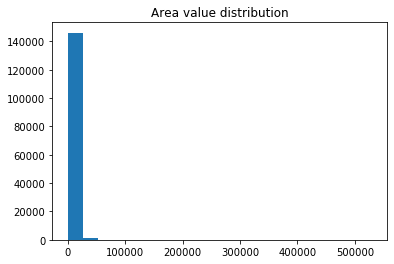

In [18]:
plt.hist(train['area'], bins=20)
plt.title('Area value distribution');

In [19]:
for i in range(50, 100, 10):
    perc = np.percentile(train['area'], i)
    print(f"{i} percentile of area is {perc}")

50 percentile of area is 5488.0
60 percentile of area is 6390.0
70 percentile of area is 7526.0
80 percentile of area is 9200.0
90 percentile of area is 12328.0


We can see that most bboxes are quite small, but there are some really huge bboxes. It would be interesting to look at them

In [20]:
def plot_image_bboxes(img_id: str = '',
                      df: pd.DataFrame = None):
    # based on Peter's kernel
    image = cv2.imread(f'/kaggle/input/global-wheat-detection/train/{img_id}.jpg', cv2.IMREAD_COLOR)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    bboxes = df.loc[df['image_id'] == img_id, ['x', 'y1', 'x1', 'y']].values
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in bboxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
    ax.set_axis_off()
    ax.imshow(image / 255)

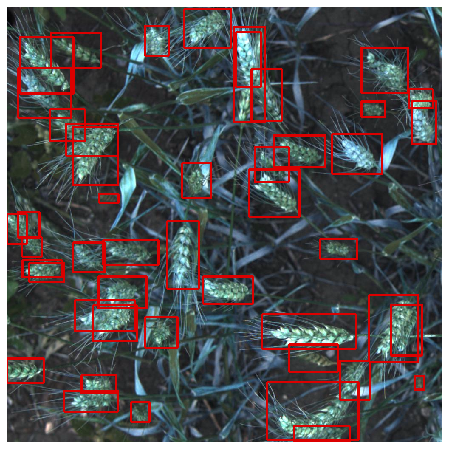

In [21]:
plot_image_bboxes('b6ab77fd7', train)

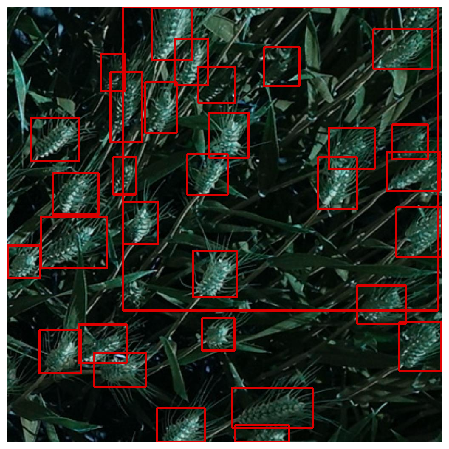

In [22]:
plot_image_bboxes('42e6efaaa', train)

Wow! There is a huge bbox on this image. I wonder whether this is normal or not.

In [23]:
valid_augs_list = [load_obj(i['class_name'])(**i['params']) for i in cfg['augmentation']['valid']['augs']]
valid_bbox_params = OmegaConf.to_container((cfg['augmentation']['valid']['bbox_params']))
valid_augs = A.Compose(valid_augs_list, bbox_params=valid_bbox_params)

In [24]:
test_img_dir = f'{cfg.data.folder_path}/test'

test_dataset = WheatDataset(None,
                             'test',
                             test_img_dir,
                             cfg,
                             valid_augs)

## Lightning class

To use pytorch-lightning, we need to define a main class, which has the following parts:
* self.hparams. This is optional parameter, but it better to use it - it is a dictionary with hyperparameters;
* forward method - making predictions with the model. The model itself can be defined outside this class;
* prepare data - preparing datasets;
* train_dataloader, val_dataloader - these methods should return the relevant dataloaders;
* configure configure_optimizers - should return lists of optimizers and schedulers;
* training_step - define what happend inside the train loop;
* validation_step - define what happend inside the validation loop;
* validation_epoch_end - define what happend at epoch end;

Please, note that some lines with `coco_evaluator` are commented out. This is because it doesn't work with numpy 1.18 - only with 1.17. And I can't downgrade the version.
I'll try to think what to do with this later.

In [25]:
class LitWheat(pl.LightningModule):

    def __init__(self, hparams: DictConfig = None, model = None):
        super(LitWheat, self).__init__()
        self.hparams = hparams
        self.model = model

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def prepare_data(self):
        datasets = get_training_datasets(self.hparams)
        self.train_dataset = datasets['train']
        self.valid_dataset = datasets['valid']

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(self.train_dataset,
                                                   batch_size=self.hparams.data.batch_size,
                                                   num_workers=self.hparams.data.num_workers,
                                                   shuffle=True,
                                                   collate_fn=collate_fn)
        return train_loader

    def val_dataloader(self):
        valid_loader = torch.utils.data.DataLoader(self.valid_dataset,
                                                   batch_size=self.hparams.data.batch_size,
                                                   num_workers=self.hparams.data.num_workers,
                                                   shuffle=False,
                                                   collate_fn=collate_fn)

        # prepare coco evaluator
#         coco = get_coco_api_from_dataset(valid_loader.dataset)
#         iou_types = _get_iou_types(self.model)
#         self.coco_evaluator = CocoEvaluator(coco, iou_types)

        return valid_loader

    def configure_optimizers(self):
        optimizer = load_obj(self.hparams.optimizer.class_name)(self.model.parameters(),
                                                                **self.hparams.optimizer.params)
        scheduler = load_obj(self.hparams.scheduler.class_name)(optimizer, **self.hparams.scheduler.params)

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        images, targets, image_ids = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # separate losses
        loss_dict = self.model(images, targets)
        # total loss
        losses = sum(loss for loss in loss_dict.values())

        return {'loss': losses, 'log': loss_dict, 'progress_bar': loss_dict}

    def validation_step(self, batch, batch_idx):
        images, targets, image_ids = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
#         self.coco_evaluator.update(res)

        return {}

    def validation_epoch_end(self, outputs):
#         self.coco_evaluator.accumulate()
#         self.coco_evaluator.summarize()
#         # coco main metric
#         metric = self.coco_evaluator.coco_eval['bbox'].stats[0]
        metric = 0
        tensorboard_logs = {'main_score': metric}
        return {'val_loss': metric, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}


## Preparing for training

There are several steps left before we can start training:
* setting random seed
* initializing the lightning class
* defining callbacks and loggers

In [26]:
set_seed(cfg.training.seed)

In [27]:
lit_model = LitWheat(hparams=cfg, model=model)

In [28]:
early_stopping = pl.callbacks.EarlyStopping(**cfg.callbacks.early_stopping.params)
model_checkpoint = pl.callbacks.ModelCheckpoint(**cfg.callbacks.model_checkpoint.params)

tb_logger = TensorBoardLogger(save_dir=cfg.general.save_dir)

## training

Training is done using special `Trainer` class

In [29]:
trainer = pl.Trainer(logger=[tb_logger],
                     early_stop_callback=early_stopping,
                     checkpoint_callback=model_checkpoint,
                     nb_sanity_val_steps=0,
                     gradient_clip_val=0.5,
                     **cfg.trainer)

In [30]:
trainer.fit(lit_model)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

## Inference

Inference will be done in another kernel. Still, below you can see how could it be done in this kernel.

In [31]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=cfg.data.batch_size,
                                          num_workers=cfg.data.num_workers,
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [32]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        pred_strings.append(f'{s:.4f} {b[0]} {b[1]} {b[2] - b[0]} {b[3] - b[1]}')

    return " ".join(pred_strings)

In [33]:
detection_threshold = 0.5
results = []
device = 'cuda'
model.eval()
for images, _, image_ids in test_loader:

    images = list(image.to(device) for image in images)
    outputs = lit_model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [34]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,cc3532ff6,0.9981 771 827 168 157 0.9978 376 0 82 98 0.99...
1,796707dd7,0.9945 0 453 66 68 0.9901 712 833 96 89 0.9888...
2,53f253011,0.9974 933 204 91 129 0.9967 235 844 110 88 0....
3,51f1be19e,0.9838 280 476 125 111 0.9837 32 0 76 68 0.981...
4,f5a1f0358,0.9962 885 649 86 135 0.9957 0 845 66 109 0.99...


In [35]:
test_df.to_csv('submission.csv', index=False)

In [36]:
torch.save(lit_model.model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')